# 所得分布：発展会計と成長会計

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import py4macro

## はじめに

一人当たりGDP（国内総生産）は経済の豊かさを示す一つの尺度として使われるが，下の左の図は2019年の世界経済での一人当たりGDPの分布を示している。日本と他の国・地域との比較を容易にするために、日本の一人当たりGDPを100として相対的な所得分布を表している。日本は38位で、１位であるルクセンブルグの一人当たりGDPは日本のそれより2倍強あり（米国は159.9で10位）、最下位のベネズエラは日本の一人当たりGDPの0.63％である。また、一人当たりGDPが日本の10％に満たない国・地域が107ある。こういった数字が示すように、世界の所得分布は大きな偏りがあり、非常に不平等である。

> （問１）なぜある国は豊かで他の国は貧しいのだろうか？

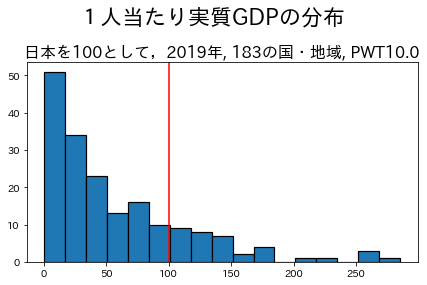

In [55]:
# データ
df = py4macro.data('pwt')
# 一人当たりGDP
df['GDPpc'] = df['rgdpe']/df['pop']
# 2019だけを取り出す
cond = (df['year'] == 2019)
df2019 = df.loc[cond, ['country','year','GDPpc']]
# 日本の値を抽出
jp = df2019.query('country=="Japan"')['GDPpc'].to_numpy()
# 日本を100として計算
df2019['GDPpc_normalized'] = 100*df['GDPpc']/jp

# プロット
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.hist(df2019['GDPpc_normalized'], bins=17, edgecolor='black', linewidth=1.2)
ax.axvline(100, c='red')
ax.set_title(f'日本を100として，2019年, {len(df2019)}の国・地域, PWT10.0', size=16)

fig.suptitle(f'１人当たり実質GDPの分布', size=22)
pass

この問いはマクロ経済学の根本的な問いである。この重要な問題を考える上で、経済成長率に関する考察を無視できない。経済成長率とは、一人当たりGDP等の変数がある一定期間（例えば、一年間）にどれだけ変化したかをパーセントで表している。「現在の所得水準は過去に達成した成長率に依存し、またこれからの成長率が将来の所得水準を決定する」という質的な結果は直感的に理解できる。では、成長率と所得水準にはどういった量的な関係があるのだろうか。これを理解するために、表１を見てみよう。


```{list-table} 表１：現在の一人当たりGDPを100として
:header-rows: 1

* - 成長率
  - 2.0%
  - 2.5%
  - 3.0%
* - 1年後
  - 102.0
  - 102.5
  - 103.0
* - 10年後
  - 121.9
  - 128.0
  - 134.4
* - 50年後
  - 269.2
  - 343.7
  - 438.4
* - 100年後
  - 724.5
  - 1181.4
  - 1921.9
```

現在の一人当たりGDPを100単位として，３つの異なる率で成長した場合、所得がどう変化するかを示している。2％と3％のケースを考えると、成長率が１％上昇するだけで、100年後の所得は約2.7倍に膨らんでいる。では、実際に各国の成長率はどれほど差があるのだろうか。それを示したのが次の図である。

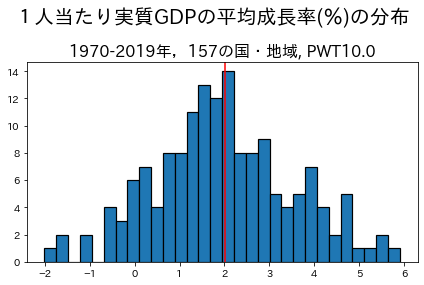

In [133]:
# 一人当たりGDP
df['naGDPpc'] = df['rgdpna']/df['pop']
# 1970を閾値とする
yr = 1970
df_growth = df.query('year >= @yr').copy()
# 成長率の計算
df_growth['growth'] = df_growth.groupby('country')[['naGDPpc']].pct_change()*100
# 平均成長率の計算
growth = df_growth.groupby('country')['growth'].mean()
# 1970以降で全ての年でGDPのデータある国・地域を抽出
notna_check = lambda x: x.notna().all()
cond = df.query('year >= @yr')[['country','year','naGDPpc']].groupby('country')['naGDPpc'].agg(notna_check)
growth = growth[cond]
# 日本の平均成長率
jp_growth = df_growth.query('country=="Japan"')['growth'].mean()
# プロット
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.hist(growth, bins=30, edgecolor='black', linewidth=1.2)
ax.axvline(jp_growth, c='red')
ax.set_title(f'{yr}-2019年，{len(growth)}の国・地域, PWT10.0', size=16)
fig.suptitle(f'１人当たり実質GDPの平均成長率(％)の分布', size=20)
pass

日本の平均成長率は2.02％であり、図では赤い直線で示している。最も高い成長率は韓国の5.91％であり，最も低い成長率はアラブ首長国連邦のマイナス2.01％である。実に、最高と最低成長率の差は7.92％ある。また、マイナスの成長率とは一人当たり所得の減少を意味するが、157の国・地域のうち14（約8.9％）が約50年の間平均して所得が縮小しているのである。

> （問２）なぜ国々の経済成長率は大きく異なるのか？

経済学者は、問１と２に対する完璧な答えを提示できておらず、今でも活発に研究がおこなわれている。この章では、問１と２についてデータと簡単な数式を使い考察する。

## データ

データは[Penn World Talbe 10.0](https://www.rug.nl/ggdc/productivity/pwt/?lang=en)を使うが，ここではデータをインポートするために`py4macro`モジュールを使う。このモジュールにはデータ・セットなどが含まれており，ここでは`data`関数を使ってデータをインポートする。使い方は次のコードで確認できる。

In [57]:
help(py4macro.data)

Help on function data in module py4macro.py4macro:

data(dataset=None, description=0)
    data関数の説明
    引数：
        dataset: (文字列)
            'pwt':   Penn World Table 10.0
            'weo':   IMF World Economic Outlook 2021
            'mad':   country data of Maddison Project Database 2020
            'mad-regions':   regional data of Maddison Project Database 2020
    
        description (デフォルト：0, 整数型):
            0: データのDataFrameを返す
            1: 変数の定義を全て表示する
            2: 変数の定義のDataFrameを返す
           -1: 何年以降から予測値なのかを全て示す(dataset='weo'場合にのみ有効)
           -2: 何年以降から予測値なのかを示すDataFrameを返す(dataset='weo'場合にのみ有効)
    
    返り値：
        DataFrame もしくは DataFrameの表示
    
    例１：py4macro.data('weo')
            -> IMF World Economic OutlookのDataFrameを返す。
    
    例２：py4macro.data('weo', description=1)
            -> IMF World Economic Outlookの変数定義の全てを表示する。
    
    例３：py4macro.data('weo', description=2)
            -> IMF World Economic Outlookの変数定義のDataFrameを返す。
    
    例４：py4macro.

````{note}
`py4macro`を事前にインストールする必要があるが，次のコマンドでインストールすることができる。
```
pip install py4macro
```
````

まず含まれていいる変数の定義を表示してみよう。`data()`の引数に`pwt`と`description=1`を指定する。

In [58]:
py4macro.data('pwt',description=1)

,Variable definition
,
Identifier variables,NaN
countrycode,3-letter ISO country code
country,Country name
currency_unit,Currency unit
year,Year
"Real GDP, employment and population levels",NaN
rgdpe,Expenditure-side real GDP at chained PPPs (in mil. 2017US$)
rgdpo,Output-side real GDP at chained PPPs (in mil. 2017US$)
pop,Population (in millions)


```{tip}
`description=1`は表示するだけなので，`DataFrame`として扱いたい場合は`description=2`とする。
```

`'pwt'`だけを引数に使うとデータ自体を読み込むことになる。

In [59]:
df = py4macro.data('pwt')

次に`.head()`を使って最初の5行を表示してみる。

In [60]:
df.head()

,countrycode,country,oecd,income_group_wb,Region,region_wb,year,rgdpe,rgdpo,pop,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,0,High income,North America,Latin America & Caribbean,1950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,0,High income,North America,Latin America & Caribbean,1951,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,0,High income,North America,Latin America & Caribbean,1952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,0,High income,North America,Latin America & Caribbean,1953,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,0,High income,North America,Latin America & Caribbean,1954,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


次の変数は上の定義のリストには含まれていない。
* `oecd`：OECDのメンバー国であれば`1`，そうでなければ`0`
* `income_group_wb`：世界銀行は所得水準に従って国を次の４つに分けており，それを使っている。
    * High income
    * Upper middle income
    * Lower middle income
    * Low income
* `region_wb`：世界銀行は次の７つの地域に国・地域をグループ化しており，それを使っている。
    * East Asia & Pacific
    * Europe & Central Asia
    * Latin America & Caribbean
    * Middle East & North Africa
    * North America
    * South Asia
    * Sub-Saharan Africa
* `region`：南極以外の6大陸
    * Africa
    * Asia
    * Australia
    * Europe   
    * North America
    * South America

属性`.columns`を使うと全ての列名を表示できる。

In [61]:
df.columns

Index(['countrycode', 'country', 'oecd', 'income_group_wb', 'Region',
       'region_wb', 'year', 'rgdpe', 'rgdpo', 'pop', 'emp', 'avh', 'hc',
       'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck', 'ctfp', 'cwtfp', 'rgdpna',
       'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr',
       'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr',
       'i_outlier', 'i_irr', 'cor_exp', 'statcap', 'csh_c', 'csh_i', 'csh_g',
       'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m',
       'pl_n', 'pl_k'],
      dtype='object')

また任意の列を選択するとメソッド`.unique()`が使えるようになる。これを使うことにより，選択した列に重複したデータがある場合，ユニークなものだけを抽出できる。このメソッドを使ってデータ・セットに含まれる国・地域名を確認してみよう。

In [62]:
country_list = df.loc[:,'country'].unique()
country_list

array(['Aruba', 'Angola', 'Anguilla', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia',
       'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia (Plurinational State of)', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Côte d'Ivoire", 'Cameroon', 'D.R. of the Congo', 'Congo',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Curaçao',
       'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt', 'Spain', 'Estonia', 'Ethiopia', 'Finland',
       'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana',
       'Guinea', 'Gambia', 'Guinea-Bissau', 'Equator

類似するメソッドに`.nunique()`がある。これを使うと，ユニークなデータの数を確認できる。

In [63]:
df.loc[:,'country'].nunique()

183

183の国・地域が含まれるということである。`unique()`でデータの年を確認することもできる。

In [64]:
year_list = df.loc[:,'year'].unique()
year_list

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

データを扱う際，必ずしもデータは「完璧な形」で提供されているわけではないことを念頭に置く必要がある。この場合，必ずしも全ての国で全ての年のデータが揃っているわけではない。ここで役に立つのが`df`のメソッド`info()`である。

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   countrycode      12810 non-null  object 
 1   country          12810 non-null  object 
 2   oecd             12810 non-null  int64  
 3   income_group_wb  12670 non-null  object 
 4   Region           12810 non-null  object 
 5   region_wb        12810 non-null  object 
 6   year             12810 non-null  int64  
 7   rgdpe            10399 non-null  float64
 8   rgdpo            10399 non-null  float64
 9   pop              10399 non-null  float64
 10  emp              9529 non-null   float64
 11  avh              3492 non-null   float64
 12  hc               8637 non-null   float64
 13  ccon             10399 non-null  float64
 14  cda              10399 non-null  float64
 15  cgdpe            10399 non-null  float64
 16  cgdpo            10395 non-null  float64
 17  cn          

この出力の読み方については[Pandasの章](pandas)で解説したので，ここでリピートする必要はないと思うが，次の点が重要となる。
* 行のインデックスは`0`から`12809`まであり，合計`12810`行ある。`countrycode`をみると`12810 non-null`となっており，`non-null`は「非欠損値（欠損値ではない）」なので，その列には欠損値がないということを意味する。一方，`hc`は`8637 non-null`となっており，`12810-8637=4173`の欠損値が存在する。
* `float64`は浮動小数点型データであり，`object`は文字列のデータと考えて良いだろう。

しかし`object`に関しては少し注意が必要となる。列に文字列が１つ混じっていて，他は`float`であっても`object`となるので注意が必要である。次の例がそれを示している。

In [66]:
pd.DataFrame({'a':[1,2,3,4,5,'1']}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   a       6 non-null      object
dtypes: object(1)
memory usage: 176.0+ bytes


そしてもう一つ。`hc`には欠損値があると分かったが，その定義を個別で確認したい場合，`py4macro`の引数`description=2`を使うと`DataFrame`が返されるので，それを使うと良いだろう。

In [67]:
teigi = py4macro.data('pwt', description=2)
teigi.loc[['hc'],:]

,Variable definition
,
hc,"Human capital index, based on years of schooli..."


ただ，これだと定義の説明が全て表示できない。その場合は`py4macro.show()`関数を使うとフルに表示できる。

In [68]:
py4macro.show(teigi.loc[['hc'],:])

,Variable definition
,
hc,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."


```{note}
上のコードで`.loc['hc',:]`とすると`Series`が返されるので，表示が少し異なることになる。
```

実際にデータを使う前に，含まれているGDPの変数について簡単に説明する。世界中の経済のGDPを比較可能な形でデータを作成するのは非常に難しい。経済によって消費・生産・輸出・輸入する財の種類・量も違えば，価格も違う。それに購買力平価（PPPs; Purchasing Power Parities; [PWTで使うPPPs](https://www.worldbank.org/en/programs/icp)）を使って経済間のGDPを実質化したとしても，時系列的に実質化するには更なる調整が必要となる。またそれぞれの政府データを使う事になるが，大きく数字が修正される場合もある。このような問題に対処するために，PWTには５つのGDPの変数が提供されている。
* データにある年のPPPsに基づき経済間の価格の違いを考慮している。
    * `cgdpo`：産出データに基づいており，時系列的には名目。ある年で経済間の生産能力（**水準**）の比較に適している。
    * `cgdpe`：支出データに基づいており，時系列的には名目。ある年で経済間の生活**水準**の比較に適している。
    * `rgdpo`：産出データに基づいており，時系列的には実質。ある期間で経済間の生産能力（**水準**）の比較に適している。
    * `rgdpe`：支出データに基づいており，時系列的には実質。ある期間で経済間の生活**水準**の比較に適している。
* ある基準年のPPPsだけに基づき経済間の価格の違いを考慮している。
    * `rgdpna`：それぞれの経済の国民経済計算を使っており，時系列的には実質。GDPの**成長率**の比較に適している。

## 発展会計

### 説明

経済間の所得格差の要因を探るために，次の生産関数を考えよう。

$$
Y_i=A_iK_i^\alpha H_i^{1-\alpha}
,\quad
H_i=h_iL_i
,\quad
0<\alpha<1
$$

* $i$：経済`i`
* $Y_i$：GDP
* $K_i$：物的資本ストック
* $A_i$：全要素生産性（TFP）
* $H_i$：人的資本ストック
* $h_i$：労働者一人当たりの人的資本ストック
* $L_i$：労働者数

GDPは労働，物的・人的資本ストックとTFPによって決定されると考える，ということである。このアプローチは「大雑把」な印象を否めないが，データを使う事により，重要な知見を得ることが可能となる。次に，生産関数を一人当たりに書き換えよう。

$$
\frac{Y_i}{L_i}=A_i
\left(
    \frac{K_i}{L_i}
\right)^{\alpha}h_i^{1-\alpha}
\quad\Rightarrow\quad
y_i=A_ik_i^{\alpha}h_i^{1-\alpha}
$$

この式を使い経済間の一人当たりGDPの違いを考察する事になる。即ち，$A_i$，$k_i$，$h_i$の違いを使って$y_i$の違いを説明しようという事
である。以下では，$k_i$と$h_i$を合わせた項を次のように呼ぶ事にする。

$$\text{蓄積生産要素：}k_i^{\alpha}h_i^{1-\alpha}$$


使うデータ・セットには，$y_i$，$k_i$，$h_i$に対応する変数があり，蓄積生産要素がどれだけ一人当たりGDPに寄与するかを数値で表すことができる。一方，全要素生産性は次の式で求めることができる。

$$A_i=\dfrac{y_i}{k_i^{\alpha}h_i^{1-\alpha}}$$

これらの式とデータを使って，一人当たりGDPに対する蓄積生産要素と全要素生産性の寄与度を数量化する事になる。

データ・セットに含まれるどの変数を使うかという問題があるが，ここでは次のデータを使うことにする。
* `rgdpo`：生産面から計算したGDP（current PPPs; in mil. 2011US\$）
    * 経済間では一定な価格を使い計算されているが、時系列的には「名目」
    * ある年に経済間の比較をするのに適している
* `emp`：雇用者数（in millions）
* `ck`：資本サービス水準（current PPPs (USA=1)）
    * 資本ストックを生産に使うことにより得るサービス    
    * データ・セットには次に２つが含まれている。
        * `cn`：資本ストック（current PPPs, in mil. 2011US\$，タクシーを例にすると車体の価額)。
        * `ck`：資本サービス（current PPPs, USA=1，タクシーを例にするとそのサービス（走行距離など）)。
* `hc`：人的資本の指標
    * 教育年数と教育の収益から計算されている

式に当てはめると次のようになる。
* 一人当たりGDP：$y_i\equiv\dfrac{Y_i}{L_i}=$ `cgdpo`/`emp`
* 一人当たり資本：$k_i\equiv\dfrac{K_i}{L_i}=$ `ck`/`emp`
* 労働者一人当たり人的資本：$h_i=$ `hc`
* 資本の所得シャア：$\alpha=1/3$を仮定

これに従ってコードを書いていこう。

In [71]:
# 資本の所得シャア
a=1/3.0

# 労働者一人当たりGDP
df['gdp_pc'] = df['cgdpo'] / df['emp']

# 一人当たり資本
df['k_pc'] = df['ck'] / df['emp']

# 蓄積生産要素
df['factors'] = df['k_pc']**a * df['hc']**(1-a)

# 全要素生産性
df['tfp'] = df['gdp_pc'] / df['factors']

### 2019年

2019年だけを抽出する。

In [72]:
df2019 = df.query('year == 2019').copy()

> `df`から2019年だけ`DataFrame`を作成し，メソッド`copy()`を使って，そのコピーを左辺の`df2019`に割り当てている。これは，ある警告が出ないようにするためである。

わかりやすくするために，全ての国の一人当たりGDPを米国の一人当たりGDPで割り、米国を１（基準）として議論を進める事にする。

In [73]:
df2019['gdp_pc_relative'] = df2019['gdp_pc'].to_numpy() / \
    df2019.query('country == "United States"')['gdp_pc'].to_numpy()

>`.to_numpy()`は`NumPy`の`array`に変換するメソッドである。

#### 物的資本

まず物的資本を考えるために，全ての国の`k_pc`を米国の`k_pc`で割り基準化する。

In [74]:
df2019['k_pc_relative'] = df2019['k_pc'].to_numpy() / \
    df2019.query('country == "United States"')['k_pc'].to_numpy()

データを散布図で確認しよう。

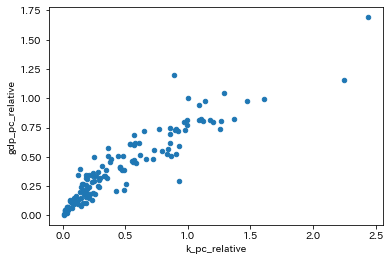

In [75]:
df2019.plot(x='k_pc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があることが確認できる。またデータの曲線トレンドは凹関数のようである。`gdp_pc_relative`に対する`k_pc_relative`増加の影響は，`k_pc_relative`が低いと大きく，`k_pc_relative`が高いと小さくなる。即ち，資本の限界生産性の低減のようにに見える。しかし，この効果のみで上の図を解釈するには問題がある。第一に，異なる経済のクロスセクション・データ（横断面データ）であるため，経済間の様々な異質性が反映されている。即ち，全ての観測値は同じ生産関数から生成されている訳ではない。第二に，資本の限界生産性の低減という概念は，労働やたの投入が一定の元での比較静学の結果である。しかし，他の投入は一定に固定されている訳ではない。一方で，これらの論点は資本の限界生産性の低減の存在を否定するものではなく，データの裏にはそのメカニズムは働いていると考える方が自然であろう。

#### 人的資本

全ての国の`hc`を米国の`hc`で割り、基準化する。

In [76]:
df2019['hc_relative'] = df2019['hc'].to_numpy() / \
    df2019.query('country == "United States"')['hc'].to_numpy()

散布図で確認してみよう。

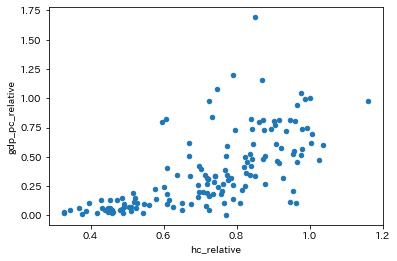

In [77]:
df2019.plot(x='hc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があることがわかる。即ち，人的資本ストックが高ければ，一人当たり所得も増えるという事であり，非常に直感的でもある。一方，物的資本と比べると，曲線トレンドは凸関数になっている。裏にあるメカニズムとして様々なことが想定できる。
* 労働者のスキルが高いため，同じ時間でより多くの財を生産できる。
* 学習能力が高いため，生産活動をとおして更にスキル向上，生産性向上につながる（学習効果）。
* 人的資本には，人に教える能力も含まれる（例えば，教師）。それにより，さらなる人的資本ストックの増加につながる。
* 人から学ぶ能力も高いため，技術・知識の伝播の速度を速め，経済全体の生産性を向上させる。
* 新しい技術・知識の創出，即ち，イノベーションを起こす必要不可欠な要素である。
* 海外からの技術移転にも貢献する。
* リスクに対する理解が深まり，リスクは高いがより生産性が高い活動への投資につながる。
* などなど

ここで見えてくるのは人的資本の「外部性」の効果である。典型的な例が，学習効果である。人的資本が増えると，生産量が高くなり学習する機会が増え，更なる人的資本の増加につながる。それが更なる生産量の増加となり，相乗効果として凸関数トレンドとして現れていると解釈できる。また，能力が上がれば，それだけ新しい知識や技術をより簡単に吸収することが可能となるだろう。更には，周りに優れた人に囲まれて仕事や勉強をすれば，それに引っ張られて自分の能力も増してくる事になるのは多くの人が経験していることではないだろうか。労働者はこのような効果を意識して（例えば，他人への効果を考慮して）行動しているわけではない。即ち，外部性が一つの基本メカニズムとして働いているという解釈が成り立つ。

一方で，違う見方を可能である。閾値効果である。図を見ると，`h_relative`が低いところから増加しても`gdp_pc_relative`は大きく増加しないが，0.7あたりから増加率が増している。0.7付近で接続される２つの直線からなる折れ線グラフのようなトレンドが想定できるのではないだろうか。変数`hc`は，教育年数が一つの決定要因となっており，`hc`が低い経済では初等教育はある程度整っているが，高等教育が十分ではないと考えられる。従って，初等教育よりも高等教育の方が生産により大きな効果をもたらすとも考えられる。

#### 全要素生産性

米国を`1`に基準化して一人当たりGDPと全要素生産性との関係を図示する。

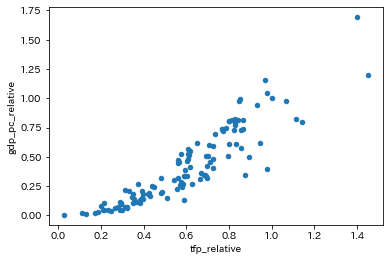

In [78]:
df2019['tfp_relative'] = df2019['tfp'].to_numpy() / \
    df2019.query('country == "United States"')['tfp'].to_numpy()

df2019.plot(x='tfp_relative', y='gdp_pc_relative', kind='scatter')
pass

正の相関関係にあることは明らかであり，凸関数トレンドを描くことができる。これは次の２つの関連するメカニズムが考えられる。
* 外部性
* 規模に関して収穫逓増

全要素生産性は，蓄積生産要素で説明できない一人当たりGDPとして定義されているが，広く使われる解釈が技術水準である。技術水準はイノベーションなどにより決定され，外部性の役割が大きいと理解されている。それを説明するために，アイザック・ニュートンが言ったとされる次の引用を考えよう。

> If I have seen further, it is by standing on the shoulders of Giants.

ここでのhave seenとはニュートンの天才的な能力・発見を指し，the shoulders of Giantsは先人が築き上げた知識・知見を意味する。ここで重要な点は，ニュートンは殆ど無料（書籍代や読書の機会費用はあるだろうが）で当時までに蓄積された知識を使うことができたということである。多くの「先人」はニュートンがアイデアを参考にするとは想定していない，もしくはアイデアを使う対価を受け取っていないと思われる訳であり，まさしく正の外部性である（研究開発には負の外部性もある）。このようなことは，今でも発生している。新薬や新しいくゲーム・ソフトを作る場合，市場にある財を参考にする。知的財産権で守られているためコピー商品は違法だが，特許で開示されている技術やデザインなどを参考に新たな財を作り出すことは日常茶飯事である。この考えを使って上のデータを解釈してみよう。技術水準が低ければ，他から学ぶ土壌が乏しい。従って，TFPが低い場合は一人当たりGDPに対する影響は限定的になる。しかし技術水準が高ければ，他からより多くを学ぶ環境が存在するため，TFPの効果はより大きなものとなって現れていると考えられる。

次に規模に関して収穫逓増を考えてみよう。TFPを計算する上でコブ・ダグラス生産関数を使ったが，規模に対して収穫一定を仮定している。もしこの仮定が間違っていて，規模に関して収穫逓増が正しい場合，`tfp_relative`に物的人的資本ストックの影響が流れ込む事になる。上で確認したように，物的人的資本ストックは一人当たり所得と正の相関があるため，それが凸関数トレンドにつながっているとも解釈できる。では，なぜ規模に関して収穫逓増になり得るのだろうか。それが技術水準や蓄積生産要素の外部性である。技術水準と人的資本の外部性について簡単に説明したが，物的資本ストックも外部性を発生させると考えられる。物的資本ストックが増えると一人当たりGDPを増加させる。それにより，人的資本の学習効果が発生し，研究開発へヒントを与えるようなきっかけにもなるかもしれない。そのような相乗効果により規模に関して収穫逓増になる生産関数を想定することも可能である。しかし，多くの研究では規模に関して収穫一定の下で議論が進められることが多いのも事実であ，以下ではそれを踏襲する。

#### 相関係数

一人当たりGDPと全要素生産性の散布図から，両変数の相関度は非常に高いと思われる。相関係数を計算してみよう。

In [79]:
df2019.loc[:,['gdp_pc_relative','tfp_relative']].dropna().corr()

,gdp_pc_relative,tfp_relative
gdp_pc_relative,1.000000,0.905357
tfp_relative,0.905357,1.000000


> `.dropna()`は`NaN`がある行を削除するメソッド<br>
> `.corr()`は相関係数を計算するメソッド

`GDPpc_relative`と`tfp_relative`の相関係数は約`0.93`であり、非常に高いことがわかる。

次に，蓄積生産要素と一人当たりGDPの散布図を作成し，相関係数を計算してみよう図示する。

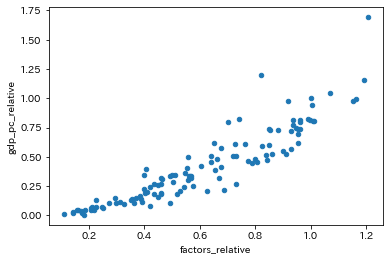

In [80]:
df2019['factors_relative'] = df2019['factors'].to_numpy() / \
    df2019.query('country == "United States"')['factors'].to_numpy()

df2019.plot(x='factors_relative', y='gdp_pc_relative', kind='scatter')
pass

In [81]:
df2019.loc[:,['gdp_pc_relative','factors_relative']].dropna().corr()

,gdp_pc_relative,factors_relative
gdp_pc_relative,1.000000,0.911408
factors_relative,0.911408,1.000000


相関係数は全要素生産性と大きく変わらない。

### 全要素生産性と蓄積生産要素の寄与度

全要素生産性と蓄積生産要素はそれぞれ一人当たりGDPにどれだけ寄与しているかを考えるために，次の方法を考える。まず生産関数を使い以下を定義する。

$$
R_i^y=R_i^{\text{tfp}}R_i^{\text{factors}}
$$

ここで

$$
R_i^y\equiv\dfrac{y_i}{y_{\text{US}}},\quad
R_i^{\text{tfp}}\equiv\dfrac{A_i}{A_{\text{US}}},\quad
R_i^{\text{factors}}\equiv\dfrac{k_i^ah_i^{1-a}}{k_{\text{US}}^ah_{\text{US}}^{1-a}}
$$

1. $R_i^y$：米国を基準とした相対所得
1. $R_i^{\text{tfp}}$：米国を基準とした相対全要素生産性
1. $R_i^{\text{factors}}$：米国を基準とした相対蓄積生産要素

両辺に対数を取り、相対所得$R_i^y$の分散を計算する。

$$
\text{Var}\left(\log\left(R_i^y\right)\right) =
\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right) +
\text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right) +
2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
$$

左辺の相対所得の変動は右辺の３つの項に分解することができる。
1. 相対全要素生産性の変動：$\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)$
1. 相対蓄積生産要素の変動：$\text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right)$
1. 相対全要素生産性と相対蓄積生産要素の共分散散：$2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)$

これを利用して

$$
\begin{align*}
\text{全要素生産性の寄与度}&=
\dfrac{
    \text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)
    +\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
    }{
    \text{Var}(\log(R_i^y))
    } \\
\text{蓄積生産要素の寄与度}&=
\dfrac{
    \text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right)
    +\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
    }{
    \text{Var}(\log(R_i^y))
    }    
\end{align*}
$$

を定義する。ここで $2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)$ は等分されている。


（考え方）

極端な例として、全ての経済の全要素生産性が同じで蓄積生産要素だけが異なる場合を考えよう。即ち，

$$
\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)
=\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
=0
$$

この場合、蓄積生産要素だけで一人当たりGDPの違いを説明できることになるため、全要素生産性の寄与度は`0`であり蓄積生産要素は`1`である。即ち、一人当たりGDP（対数）の分散に対して分散がより大きいほど説明力が高いといえる。

In [82]:
# 欠損値であるNaNがある行を削除
df2019_nonan = df2019.dropna(subset=['gdp_pc_relative','tfp_relative', 'factors_relative'])

# それぞれの変数（対数）を設定
tfp     = np.log(df2019_nonan['tfp_relative'])
factors = np.log(df2019_nonan['factors_relative'])
gdp_pc  = np.log(df2019_nonan['gdp_pc_relative'])

# 分散・共分散の計算
tfp_var         = tfp.var()
factors_var     = factors.var()
gdp_pc_var      = gdp_pc.var()
tfp_factors_cov = np.cov(tfp.values,factors.values)[0,1]

**全要素生産性の寄与度**

In [83]:
(tfp_var + tfp_factors_cov) / gdp_pc_var

0.5045124027276576

相対所得の変動の約`50`%は全要素生産性によって説明される。

**蓄積生産要素の寄与度**

In [84]:
(factors_var + tfp_factors_cov) / gdp_pc_var

0.4954875972723427

相対所得の変動の約`50`%は蓄積生産要素によって説明される。

**結果**

2019年の一人当たりGDPの変動の50%は全要素生産性によって説明され，残りの50%は蓄積生産要素によって説明される。即ち，一人当たりGDPの決定要因としての全要素生産性と蓄積生産要素は重要性は同等である。

### 表の作成

最後に、主要な国のデータを表にまとめてみる。

In [85]:
#（１）〜（４）については以下で説明する。

#（１）
country_table = ['Japan', 'United Kingdom','United States', 'Norway',
                'Mexico','Peru','India','China','Zimbabwe','Niger']

#（２）
cond = df2019['country'].isin(country_table)

#（３）
col = ['country','gdp_pc_relative','tfp_relative','factors_relative']

#（４）
table2019 = df2019.loc[cond,col].set_index('country') \
                  .sort_values('gdp_pc_relative', ascending=False) \
                  .round(2) \
                  .rename(columns={'gdp_pc_relative':'一人当たりGDP',
                                   'tfp_relative':'全要素生産性',
                                   'factors_relative':'蓄積生産要素'})

print('米国を１として')
table2019

米国を１として


,一人当たりGDP,全要素生産性,蓄積生産要素
country,,,
Norway,1.05,0.98,1.07
United States,1.00,1.00,1.00
United Kingdom,0.70,0.73,0.95
Japan,0.55,0.62,0.90
Mexico,0.33,0.59,0.57
China,0.19,0.42,0.46
Peru,0.18,0.40,0.46
India,0.14,0.40,0.35
Zimbabwe,0.05,0.21,0.22


上のコードを説明する。
* (１）：表示する国のリスト
* (２）：列`country`に`country_list`にある国名と同じであれば`True`、異なる場合は`False`を返す条件を作成している。
    * `.isin()`はそのためのメソッド
* (３）：表の列ラベルに使う変数リスト
* (３）：`DataFrame`を作成する。
    * `.loc[cond,col]`を使い、`cond`の条件に合った行、そして`col`の列を抽出する。
    * `.set_index('country')`は`country`の列を行ラベルに設定するメソッド。
    * `.sort_values()`は`DataFrame`を列`gdp_pc_relative`に従って並び替えるメソッドであり、`ascending=False`は降順を指定している。
    * `.round(2)`は表示する小数点を第二桁までで四捨五入することを指定するメソッド。
    * `.rename()`は列ラベルを変更するメソッド。
    
＜コメント＞ `print()`関数を使うとテキストとして表示される。

In [86]:
print(f"日本の全要素生産性は米国の{table2019.loc['Japan','全要素生産性']*100}%であり，"
      f"蓄積生産要素は米国の{table2019.loc['Japan','蓄積生産要素']*100}%である。")

日本の全要素生産性は米国の62.0%であり，蓄積生産要素は米国の90.0%である。


## 成長会計

### 説明

発展会計では一人当たりGDPを分解し、全要素生産性と蓄積生産要素に分けてその寄与度を考えた。成長会計では、一人当たりGDPの**変化率**（即ち、経済成長率）を同じように２つの要素に分解しそれぞれの寄与度を考察する。$t$時点の生産関数は

$$
y_t=A_tk_t^ah_t^{1-a}
$$

とすると、$t$時点と$t+1$時点の生産関数を使うと

$$
\frac{y_{t+1}}{y_t}=\frac{A_{t+1}}{A_t}\left(\frac{k_{t+1}}{k_t}\right)^a\left(\frac{h_{t+1}}{h_t}\right)^{1-a}
$$

となる。ここで

$$
1+g_x\equiv\frac{x_{t+1}}{x_t}
$$

としよう。$g_x$は$x$の成長率（例えば、0.02）である。これにより、

$$
    1+g_y=(1+g_A)(1+g_k)^a(1+g_h)^{1-a}
$$

となり、対数化すると

$$
    \log(1+g_y)=\log(1+g_A)+a\log(1+g_k)+(1-a)\log(1+g_h)
$$

となる。また成長率が十分に小さい場合（例えば、0.02）、次式で近似することが可能となる。

$$
\log(1+g_x)\approx g_x
$$

In [137]:
np.log(1+0.02)

0.01980262729617973

即ち、

$$
    g_y=g_A+ag_k+(1-a)g_h
$$

使うデータの期間を$n$とし、変数$x$の$n$年間の年間平均成長率を$g_x$としよう。この場合、次式が成立する。

$$
\frac{x_{n}}{x_{0}}=(1+g_x)^{n}
$$

この式を書き直すと次式となる。

$$
g_x=
\left(
\dfrac{x_{n}}{x_{0}}
\right)^{\frac{1}{n}}-1
$$

Penn World Tableの次の変数を使う。
* `rgdpna`：実質GDP
    * 経済成長を考える上で適している
* `emp`：雇用者数
* `rnna`：資本ストック
* `hc`：人的資本の指標
    * 教育年数と教育の収益から計算されている

以下で計算する変数とは次のように対応している。
* 一人当たりGDP：$y_i\equiv\dfrac{Y_i}{L_i}=$ `rgdpna`/`emp`
* 一人当たり資本：$k_i\equiv\dfrac{K_i}{L_i}=$ `rnna`/`emp`
* 労働者一人当たり人的資本：$h_i=$ `hc`
* 資本の所得シャア：$\alpha=1/3$（仮定）
* 蓄積生産要素の寄与：$k_i^{\alpha}h_i^{1-\alpha}$
* 全要素生産性：$A_i=\dfrac{y_i}{k_i^{\alpha}h_i^{1-\alpha}}$

それぞれの変数を計算しよう。

In [138]:
# 資本の所得シャア
a=1/3.0

# 一人当たりGDP
df['rgdp_pc'] = df['rgdpna'] / df['emp']

# 資本割合
df['k_pc'] = df['rnna'] / df['emp']

# 蓄積生産要素
df['factors'] = df['k_pc']**a * df['hc']**(1-a)

# 全要素生産性
df['tfp'] = df['rgdp_pc'] / df['factors']

### 平均成長率の計算

まず2009年から2019年の10年間の`rgdp_pc`、`k_pc`、`hc`の平均成長率を計算する。次のコードを使うが`for`ループが二重（入れ子）になっている。

In [139]:
var_list = ['rgdp_pc','k_pc','hc']   # (1)

dic = {}             # (2)

for v in var_list:   # (3)
    
    g_list = []             # (4)
    
    for c in country_list:  # (5)
        start = 2009        # (6)
        end = 2019          # (7)
        n = end-start       # (8)
        
        df_start = df.query('country == @c & year == @start')  # (9)
        df_end = df.query('country == @c & year == @end')      # (10)


        g = ( df_end[v].iat[0] / df_start[v].iat[0] )**(1/n)-1  # (11)
        g_list.append(100*g)                                    # (12)
            
    dic[v] = g_list          # (13)


df_growth = pd.DataFrame({'country':country_list,               # (14)
                          'rgdp_pc':dic['rgdp_pc'],             # (15)
                          'k_pc':dic['k_pc'],                   # (16)
                          'hc':dic['hc']})                      # (17)

* (1)：成長率を計算する対象となる変数リスト
* (2)：空の辞書。次の形になるように(1)の平均成長率のリストを格納する。
    * キー：変数名（`rgdp_pc`、`k_pc`、`hc`）
    * 値：それぞれの国の成長率からなるリスト
* (3)：(1)の`var_list`に対しての`for`ループ。１回目のループでは`rdgp_pc`について計算する。
* (4)：空リスト（役割は以下で説明）
* (5)：`country_list`に対しての`for`ループ。(3)の１回目の`for`ループで変数`rdgp_pc`に対して`country_list`にある国の成長率を下に続くコードを使って計算する。
    * (6)：最初の年を指定
    * (7)：最後の年を指定
    * (8)：何年間かを計算
    * (9)：最初の年の`DataFrame`を抽出
    * (10)：最後の年の`DataFrame`を抽出
    * (11)：平均成長率を計算する。
        * `df_end[v]`と`df_start[v]`は列ラベル`v`の列を抽出しており、`Series`として返される。
        * `.iat[0]`は`Series`の`0`番目の数値を取り出すメソッド
    * (12)：計算した成長率を(4)のリストに追加する。
        * `100`をかけて％表示にする。
* (13)： (5)のループが終わると、(4)のリストを(2)の辞書に追加する
    * 辞書に追加する際に変数名`v`を指定することにより、次のペアのデータが追加される
        * キー：変数名（`rgdp_pc`、`k_pc`、`hc`）
        * 値：それぞれの国の成長率のリスト
* (3)の`for`ループの次の変数に移り、上で説明した作業が繰り返される。
* (14)：`country_list`を`DataFrame`の列に設定
* (15)〜(17)：それぞれの成長率を`DataFrame`の列に設定
    * `dic['キー']`で`dic`の`キー`にあるリストを抽出している。

In [140]:
df_growth.head()

,country,rgdp_pc,k_pc,hc
0,Aruba,0.734869,1.094933,NaN
1,Angola,-0.991189,-0.449191,0.537529
2,Anguilla,NaN,NaN,NaN
3,Albania,0.792894,0.978772,0.230371
4,United Arab Emirates,1.622983,1.674040,0.118918


欠損値が含まれているので、`NaN`がある行は全て削除する。

In [141]:
df_growth = df_growth.dropna()

残った国数を確認する。

In [142]:
len(df_growth)

144

`rgdp_pc`の成長率のヒストグラムを図示しよう。方法は簡単で，使用する列を選んでメソッド`plot()`の引数を`kind='hist'`とするだけである。`bins=20`は階級（棒）の数を指定する引数（デフォルトは`10`）と理解すれば良いだろう。

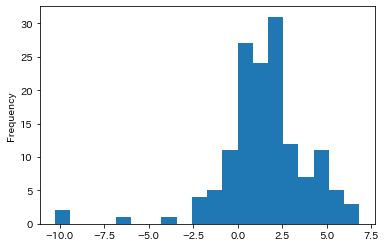

In [188]:
df_growth['rgdp_pc'].plot(kind='hist',bins=20)
pass

多くの国はプラスの経済成長を遂げているが，マイナイス成長の経済も少なからず存在する。平均成長率がマイナスの国数を計算してみよう。

In [144]:
len(df_growth.query('rgdp_pc < 0'))

24

平均成長率が約-10%の経済があるが，国名を探してみよう。

In [145]:
df_growth_sorted = df_growth.sort_values('rgdp_pc')
df_growth_sorted.head()

,country,rgdp_pc,k_pc,hc
179,Yemen,-10.259679,-0.605331,2.872344
176,Venezuela (Bolivarian Republic of),-9.486451,0.323033,1.274472
158,Syrian Arab Republic,-6.282065,1.498543,1.014550
37,Congo,-3.503272,2.635093,0.115613
94,Kuwait,-2.485174,2.457676,0.625742


ここで使ったメソッド`sort_values()`は，引数の列を基準に昇順に並べ替える。引数に`ascending=False`を使うと，降順に並び替えることができる。

In [146]:
print( '上のヒストグラムで`-10`付近に位置する国は'
      f'{df_growth_sorted.iloc[0,0]}と{df_growth_sorted.iloc[1,0]}である。')

上のヒストグラムで`-10`付近に位置する国はYemenとVenezuela (Bolivarian Republic of)である。


### 蓄積生産要素の成長率

次に，下の式を使って蓄積生産要素の成長率を計算しよう。

$$
g_{\text{factors}}=ag_k+(1-a)g_h
$$

結果を`df_growth`に追加するが，その際、$a=\dfrac{1}{3}$と仮定する。

In [147]:
df_growth['factors'] = (1/3)*df_growth['k_pc']+(1-1/3)*df_growth['hc']

`factors`の成長率のヒストグラムを図示する。

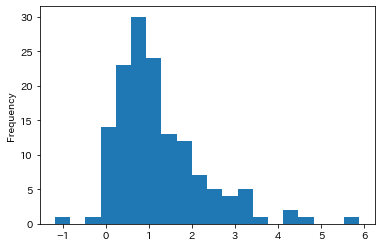

In [148]:
df_growth['factors'].plot(kind='hist',bins=20)
pass

一人当たりGDPの成長率と比べると，マイナスの成長率の国は少ないことがわかる。

In [149]:
len(df_growth.query('factors < 0'))

5

### 全要素生産性

全要素生産性は残差として計算される。

$$
g_A=g_y-g_{\text{factors}}
$$

In [151]:
df_growth['tfp'] = df_growth['rgdp_pc'] - df_growth['factors']

`tfp`の成長率のヒストグラムを図示してみよう。

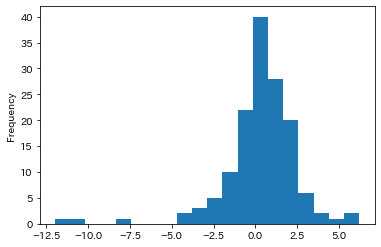

In [152]:
df_growth['tfp'].plot(kind='hist',bins=20)
pass

蓄積生産要素と比べると全要素生産性の成長率はよりマイナスに広がっている。

### 全要素生産性と蓄積生産要素の貢献度

全要素生産性と蓄積生産要素のどちらが成長率に貢献しているのだろうか。まず図を使って比較してみよう。

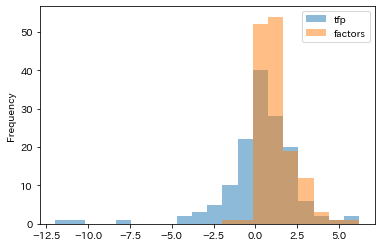

In [153]:
df_growth[['tfp','factors']].plot(kind='hist',bins=20,alpha=0.5)
pass

＜コードの説明＞
> ２つの列を選択することにより，同じ図に２つのヒストグラムが表示できるようになる。
>
> 引数`alpha`は図の透過度を指定する。0から1の間の値が指定可能で，デフォルトは1（透過なし）。

図から次のことがわかる。蓄積生産要素の成長率は正の値になる傾向がある。即ち，殆どの経済で蓄積生産要素による経済成長が起こっているということである。一方，全要素生産性の成長率はマイナスへの広がりがあり，成長を妨げる要因になっているようである。

次に，一人当たりGDPの成長率に対する全要素生産性の貢献度を数量化するが，２つの方法を考えよう。

#### 方法１

全要素生産性の貢献度を次の式で計算する。

$$
100\times\frac{g_{A}}{g_y}
$$

In [154]:
df_growth['tfp_contribution'] = 100 * df_growth['tfp']/df_growth['rgdp_pc']

全要素生産性の貢献度が`50`％以上の国は何％かを計算する。

In [155]:
tfp_contribution_more_than_50 = 100 * len(df_growth.query('50<=tfp_contribution')) / len(df_growth)

In [156]:
print(f'約{tfp_contribution_more_than_50:.1f}％の国で全要素生産性がより大きな貢献をしている。')

約50.7％の国で全要素生産性がより大きな貢献をしている。


#### 方法２

２つ目の方法として発展会計で使った方法を考える。

$$
g_{yi} = g_{Ai} + g_{\text{factors},i}
$$

従って、分散を計算すると

$$
\text{Var}\left(g_{yi}\right)=
\text{Var}\left(g_{Ai}\right)+
\text{Var}\left(g_{\text{factors},i}\right)
+2\text{Cov}\left(g_{Ai},g_{\text{factors},i}\right)
$$

となり、次式を定義することができる。

$$
\begin{align*}
\text{全要素生産性の寄与度}&=
\dfrac{
    \text{Var}\left(g_{Ai}\right)+
    \text{Cov}\left(g_{Ai},g_{\text{factors},i}\right)
    }{
    \text{Var}\left(g_{yi}\right)
    } \\
\text{生産要素の寄与度}&=
\dfrac{
    \text{Var}\left(g_{\text{factors},i}\right)+
    \text{Cov}\left(g_{Ai},g_{\text{factors},i}\right)
    }{
    \text{Var}\left(g_{yi}\right)
    }    
\end{align*}
$$

これらの式に従って計算してみよう。

In [159]:
# それぞれの変数を設定
tfp_growth     = df_growth['tfp']
factors_growth = df_growth['factors']
rgdp_pc_growth = df_growth['rgdp_pc']

# 分散・共分散の計算
tfp_growth_var         = tfp_growth.var()
factors_growth_var     = factors_growth.var()
rgdp_pc_growth_var     = rgdp_pc_growth.var()
tfp_factors_growth_cov = np.cov(tfp_growth, factors_growth)[0,1]

**全要素生産性の寄与度**

In [160]:
(tfp_growth_var + tfp_factors_growth_cov) / rgdp_pc_growth_var

0.8443024051814619

**蓄積生産要素の寄与度**

In [161]:
(factors_growth_var+ tfp_factors_growth_cov) / rgdp_pc_growth_var

0.15569759481853807

蓄積生産要素よりも全要素生産性の寄与度が高いことが確認できる。この結果は，両変数の成長率のヒストグラムからも示唆される。全要素生産性の成長率の方が変動が大きいため，一人当たりGDPの成長率の変動のより多くを説明できる事になる。

### 表の作成

結果を表としてまとめてみる。右端の列は方法１の結果を使っている。

In [108]:
country_table = ['Japan', 'United Kingdom','United States', 'Norway',
                'Singapore','Peru','India','China']

cond = df_growth['country'].isin(country_table)

col = ['country','rgdp_pc','factors','tfp','tfp_contribution']

df_growth.loc[cond,col].set_index('country') \
         .sort_values('rgdp_pc', ascending=False) \
         .round(2) \
         .rename(columns={'rgdp_pc':'一人当たりGDPの成長率',
                          'factors':'蓄積生産要素の成長率',
                          'tfp':'全要素生産性の成長率',
                          'tfp_contribution':'全要素生産性の寄与度(％)'})

,一人当たりGDPの成長率,蓄積生産要素の成長率,全要素生産性の成長率,全要素生産性の寄与度(％)
country,,,,
India,5.90,2.77,3.13,53.04
China,4.76,3.36,1.40,29.33
Singapore,2.46,3.30,-0.84,-34.14
Peru,2.43,1.66,0.77,31.64
United States,1.14,0.17,0.97,84.88
Japan,0.70,0.06,0.64,90.85
United Kingdom,0.61,0.21,0.41,66.08
Norway,0.40,0.61,-0.21,-53.25


### 日本

関数を使って日本の成長パフォーマンスを考えてみる。次の関数は`start`から`end`までの間の平均成長率と全要素生産性の寄与度をリストとして返す。

In [163]:
def jp_growth_decomposition(start, end):

    var_list = ['rgdp_pc','k_pc','hc']
    
    start = start
    end = end
    n = end-start
    
    df_start = df.query('country == "Japan" & year == @start')
    df_end = df.query('country == "Japan" & year == @end')
    
    g_list = []
    
    
    # ========== var_listの変数の平均成長率を計算しg_listに追加する ==========
    for v in var_list:
        
        g = ( df_end[v].iat[0] / df_start[v].iat[0] )**(1/n)-1
        g_list.append(100*g)

        
    # ========== 蓄積生産要素の平均成長率を計算しg_listに追加する ==========
    factors = (1/3)*g_list[1]+(1-1/3)*g_list[2]
    g_list.append(factors)

    
    # ========== 全要素生産性の平均成長率を計算しg_listに追加する ==========
    tfp = g_list[0]-factors
    g_list.append(tfp)

    # ========== 全要素生産性の寄与度を計算しg_listに追加する ==========
    tfp_contribution = 100*tfp/g_list[0]
    g_list.append(tfp_contribution)
    
    return g_list

この関数を使って`DataFrame`を作成する。

In [164]:
# 10年ごとの平均成長率からなる辞書
dic = {'1950s':jp_growth_decomposition(1950,1959),
       '1960s':jp_growth_decomposition(1960,1969),
       '1970s':jp_growth_decomposition(1970,1979),
       '1980s':jp_growth_decomposition(1980,1989),
       '1990s':jp_growth_decomposition(1990,1999),
       '2000s':jp_growth_decomposition(2000,2010),
       '2010s':jp_growth_decomposition(2010,2019)}

# 下のDataFrameで使うインデックス
idx = ['gdp_pc_growth','k_pc_growth','hc_growth',
       'factors_growth','tfp_growth','tfp_contribution']

df_jp = pd.DataFrame(dic, index=idx)
df_jp

,1950s,1960s,1970s,1980s,1990s,2000s,2010s
gdp_pc_growth,5.818810,8.574257,3.828061,3.638507,0.905053,0.622765,0.308059
k_pc_growth,3.332503,10.090416,7.889281,3.718257,2.679254,0.502367,-0.471598
hc_growth,1.265048,0.807691,0.711507,0.560457,0.516702,0.443183,0.303400
factors_growth,1.954199,3.901933,3.104098,1.613057,1.237552,0.462911,0.045067
tfp_growth,3.864610,4.672324,0.723963,2.025450,-0.332500,0.159854,0.262992
tfp_contribution,66.415824,54.492467,18.911993,55.667066,-36.738169,25.668408,85.370519


値を確認するだけであればこのままでも良いが，棒グラフを作成するために列と行を入れ替えることにする。`df_jp`のメソッド`.transpose()`を使う。

In [165]:
df_jp = df_jp.transpose()
df_jp

,gdp_pc_growth,k_pc_growth,hc_growth,factors_growth,tfp_growth,tfp_contribution
1950s,5.818810,3.332503,1.265048,1.954199,3.864610,66.415824
1960s,8.574257,10.090416,0.807691,3.901933,4.672324,54.492467
1970s,3.828061,7.889281,0.711507,3.104098,0.723963,18.911993
1980s,3.638507,3.718257,0.560457,1.613057,2.025450,55.667066
1990s,0.905053,2.679254,0.516702,1.237552,-0.332500,-36.738169
2000s,0.622765,0.502367,0.443183,0.462911,0.159854,25.668408
2010s,0.308059,-0.471598,0.303400,0.045067,0.262992,85.370519


一人当たりGDP成長率`gdp_pc_growth`を棒グラフとして表示してみよう。表示したい列を選択し，引数に`kind='bar'`を選択するだけである。

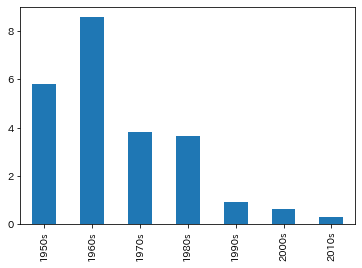

In [196]:
df_jp['gdp_pc_growth'].plot(kind='bar')
pass

1960年代をピークに成長率は下降線をたどっている。

次にヒストグラムに異なる変数を並べて表示してみる。この場合も、表示したい変数を先に選び`kind='bar'`を指定するだけである。

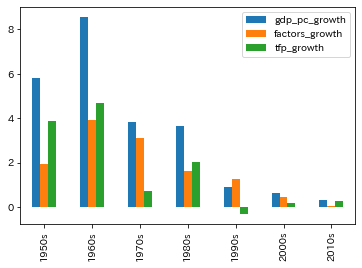

In [197]:
df_jp.iloc[:,[0,3,4]].plot(kind='bar')
pass

`stacked=True`を設定すると棒グラフを積み重ねて表示することができる。

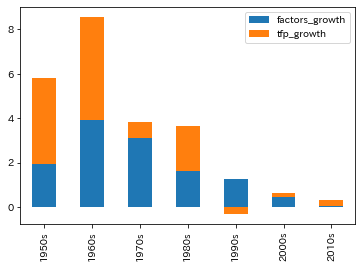

In [198]:
df_jp.iloc[:,[3,4]].plot(kind='bar', stacked=True)
pass

次のグラフでは線グラフと一緒に表示している。

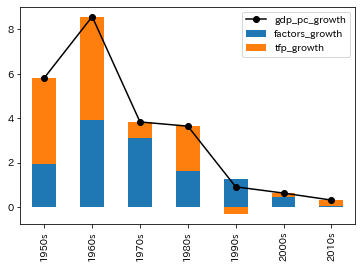

In [199]:
ax_ = df_jp.iloc[:,0].plot(marker='o',color='k', legend=True)
df_jp.iloc[:,[3,4]].plot(kind='bar', stacked=True, legend=True, ax=ax_)
pass

1990年代に全要素生産性の成長率はマイナスとなり，一人当たりGDPの成長率は大きく下落している。「失われた10年」の原因と主張する研究者もいる。

## 所得分布の推移

世界経済の所得分布が時間と共にどのように変化したかを考える。手法としては，一人当たりGDPの分布自体の変化を図示して確認する。分析に使うデータはPenn World Talbeの次の２変数：
* `rgdpe`：支出面から計算したGDP（連鎖PPPs; in mil. 2017US\$）
    * 経済間そして時系列的にも一定な価格を使い計算されてい「実質」
    * 経済間そして時間の次元での比較に適している
* `pop`：人口（in millions）

一人当たりGDPの変数（対数）を作成する。

In [169]:
df['gdp_pc_log'] = np.log( df['rgdpe'] / df['pop'] )

2019年の日本の一人当たりGDP

In [170]:
y_jp = df.query('country == "Japan" & year == 2019')['gdp_pc_log']
y_jp

6159    10.587516
Name: gdp_pc_log, dtype: float64

このコードで返されるのは`Series`なので，`gdp_pc_log`の値自体を抽出するためには`.iloc[]`を使う。

In [172]:
y_jp.iloc[0]

10.587515569810463

次に2019年のヒストグラムを作成しよう。

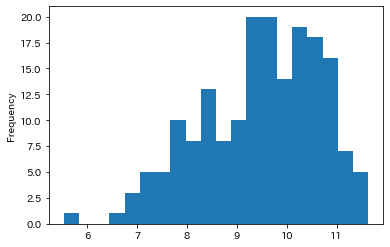

In [174]:
df.query('year == 2019')['gdp_pc_log'].plot(kind='hist', bins=20)
pass

ヒストグラムは縦軸に度数，横軸に階級を取ったグラフだが，関連する手法に[カーネル密度推定](https://en.wikipedia.org/wiki/Kernel_density_estimation)と呼ばれるものがある。考え方は簡単で，上のようなヒストグラムのデータに基づき面積が１になるようにスムーズな分布を推計する手法である。詳細は割愛するが，下のコードではヒストグラムとカーネル密度関数を重ねてプロットする。

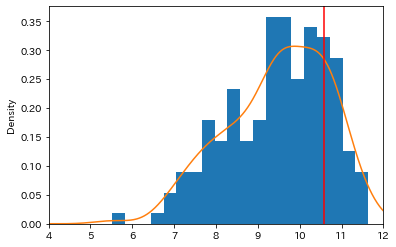

In [178]:
# ヒストグラム
ax_ = df.query('year == 2019')['gdp_pc_log'].plot(kind='hist', bins=20, density=True)

# 密度関数
df.query('year == 2019')['gdp_pc_log'].plot(kind='density',ax=ax_)

# 日本
ax_.axvline(y_jp.iloc[0],color='red')

# 横軸の表示範囲
ax_.set_xlim(4,12)
pass

>＜コードの説明＞
>* `density=True`は縦軸を確率として表示する引数
>* `kind='density'`は分布のスムーズな形を推定し表示する引数（密度関数を推定する）
>* `axvline()`は`ax_`のメソッドであり，横軸の第一引数の値に垂直線を表示する。`color`は色を指定する引数。
>* `set_xlim()`は横軸の表示範囲を指定する。

最頻値（モード）は中心より右側にあるが，横軸は対数になっていることを思い出そう。対数を取らない分布では，最頻値は分布の中心より左側に位置することになる。試してみよう。

ここで確かめたいのは，約70年の間に上の所得分布のどのように変化してきたか，という問題である。この問いに答えるために，カーネル密度関数（`kind=density`）を使って1950年から10年毎の分布を表示する。

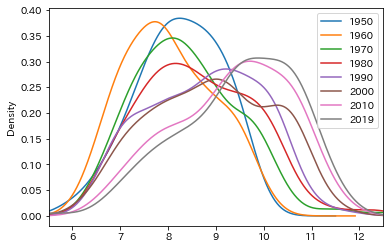

In [192]:
yr_list = list(range(1960,2020,10))+[2019]                        # (1)

ax_ = df.query('year == 1950')['gdp_pc_log'].plot(kind='density', # (2)
                                                  label='1950',
                                                  legend=True)

for y in yr_list:                                                 # (3)
    df.query('year == @y')['gdp_pc_log'].plot(kind='density',     # (4)
                                              label=str(y),
                                              legend=True,
                                              ax=ax_)

ax_.set_xlim([5.5,12.5])                                          # (5)
pass

> ＜コードの説明＞
>* (1) `range(start, end, step)`は`start`から`end`までの整数を`step`の間隔で準備する。更に`list()`を使ってリストに変換し，`+[2019]`を使ってリストの最後に`2019`を追加している。
>* (2) 1950年の密度関数を表示し，その「軸」を`ax_`に割り当てる。
>* (3) `yr_list`に対しての`for`ループで1960から10年毎のループとなる。
>* (4) `for`ループの中で表示する密度関数
    * 「軸」を選ぶ引数`ax`には`ax_`を選んでいる。
>* (5) `ax_`のメソッドである`set_xlim()`は横軸の表示範囲を指定する。
    * 最小値，最大値をリストもしくはタプルで指定する。
    * `set_xlim()`が設定されない場合は，自動で設定される。

分布の偏り（もしくは頂点）が左から右に移っているように見える。一方，1960年の分布の最頻値（モード）は1950年のそれの左に位置している。これは，それぞれの年に`gdp_pc`が`NaN`ではない国数は変わっており，1950年と1960年のサンプルにある国数は大きく違うためである。それぞれの年の国数を調べるために，次のコードを実行してみよう。

In [122]:
df.query('year == 2019')['gdp_pc_log'].notna().sum()

183

>＜コードの説明＞
>* `notna()`は要素が`NaN`かどうかを調べるメソッドである。要素が`NaN`であれば`False`を，`NaN`でなければ`True`を返す。
>* `True`は`1`と数えられるので，メソッド`sum()`を使うことにより`True`の数，即ち，`NaN`ではない要素の数を返す。

`for`ループを使って数えてみよう。

In [123]:
print('gdp_pc_logに含まれる国数：\n----------------------')

for y in [1950]+yr_list:
    
    no = df.query('year == @y')['gdp_pc_log'].notna().sum()

    print(f'{y}：{no}')

gdp_pc_logに含まれる国数：
----------------------
1950：55
1960：111
1970：157
1980：157
1990：181
2000：181
2010：183
2019：183


データが整備されている国は典型的に先進国であり，後から含まれる国は比較的に所得が低い経済である。従って，貧しい国が所得分布に含まれることにより，分布は左側に引っ張られる傾向にある。特に，1950年から1960年には2倍以上になっており，上で説明したように，その影響で1960年の最頻値（モード）は1950年のそれよりも低くなっている。1960年以降も国数は増え続けるが，それでも分布の最頻値が右に移って行くということは，貧しい国が豊かな国に少しずつ追いついていることを示している。例えば，台湾，シンガポール，香港，韓国，中国やインドなど。

次に，分布の広がりの指標として変動係数を考えてみる。

変動係数（Coefficient of Variation）＝$\dfrac{\text{標準偏差}}{\text{平均}}$

変動係数は，平均値１単位あたりの標準偏差を表しており，平均値を使って標準化することにより分布の幅の程度を比べることが可能となる。

In [193]:
cv_list = []   # 空のリスト

for y in year_list:
    stdev = df.query('year == @y')['gdp_pc_log'].std()  # 標準偏差の計算
    avr = df.query('year == @y')['gdp_pc_log'].mean()   # 平均の計算
    cv = stdev / avr                                    # 変動係数の計算
    cv_list.append(cv)                                  # リストに追加

df_cv = pd.DataFrame({'CV':cv_list}, index=year_list)

最後の行の引数`index=year_list`はインデックスにyear_listを設定しており，それにより，次のコードでは自動的に横軸が年になる。

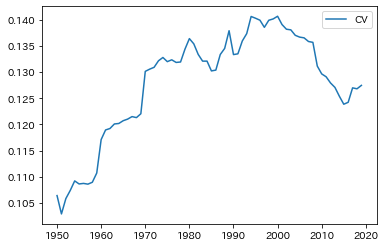

In [194]:
df_cv.plot()
pass

サンプルに含まれる国数が徐々に増えており，その影響により変動係数は増える傾向にある。1990年ごろには国数の増加は少なくり，それと同時に変動係数は減少し始めている。即ち，少なくとも1990年頃から経済間の所得格差は減少している。

＜これまでの分析で注意する点＞
* 分析の対象は国であり，それぞれの国の一人当たりGDPのみを考えた。
* **国内**の所得不平等は全く考慮されていない。
* 年によって計算に含まれる国数が異なる。